In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

As of now, there are TWO main questions Elite F1 would like to know:  
1. What player performance associates stronly with the easiness of the Final Round groups on Sundays?
2. What player performance associates with falling with other fellow players in the same groups? Essentially, Elite F1 wants to understand how players are assigned to groups.

I have ideas about answering the first question. We can simply use linear regression (see: https://machinelearningmastery.com/linear-regression-for-machine-learning/) to see if a pattern emerges.

#### Importing libraries. Making my life easier!

In [9]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm, trange

In [10]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

#### Reading the data

In [11]:
raw_data = pd.read_csv("../../data/GP_220123.csv")

#### Data clean up

In [12]:
# Subsetting the data to get the columns I want for initial analysis
# Also, deleting rows that have no player name
cleaned_data_regression = raw_data[['Player', 'Score for P10 on his group',
                                    '# of 470 on his group', 'AVG qualy + opening',
                                    'SUM qualy + opening', 'Races qualy + opening',
                                    'SAT score', 'SAT races', 'AVG 3 qualy',
                                    'Score 3 qualy', 'Races 3 qualy','Actual qualy day', 
                                    'FRI score', 'FRI races', 'THU score', 'THU races',
                                    'WED score', 'WED races']].dropna(subset=['Player'])

In [13]:
# Detour: Some REALLY ANNOYING transformations
cleaned_data_regression = cleaned_data_regression.replace({"X": np.nan})
cleaned_data_regression['Score for P10 on his group'] = cleaned_data_regression['Score for P10 on his group'].astype(float)
cleaned_data_regression['AVG qualy + opening'] = cleaned_data_regression['SUM qualy + opening']/cleaned_data_regression['Races qualy + opening']
cleaned_data_regression['AVG 3 qualy'] = cleaned_data_regression['Score 3 qualy']/cleaned_data_regression['Races 3 qualy']

# or missing the key dependent variables
cleaned_data_regression = cleaned_data_regression.dropna(how='any',
                                                         subset=['Score for P10 on his group',
                                                                 '# of 470 on his group'])


# or key independent variables. For example:
a = cleaned_data_regression['SUM qualy + opening'] > cleaned_data_regression['SAT score']
cleaned_data_regression = cleaned_data_regression.loc[a].drop('Player', axis=1).fillna(0)

In [15]:
target_variable = cleaned_data_regression['Score for P10 on his group']

ideal_target_variable = np.random.normal(460,3,50)

fig, ax = plt.subplots(1,2, figsize=(15,8))
sns.histplot(target_variable, ax=ax[0], bins='fd')
ax[0].set_ylabel('# of clan players', size=18)
ax[0].set_xlabel("Score of P10 in player's group", size=18)
ax[0].set_title("Distribution of P1 scores from last GP", size=18)
ax[0].tick_params(axis='x', labelsize=18)
ax[0].tick_params(axis='y', labelsize=18)

sns.histplot(ideal_target_variable, ax=ax[1], bins='fd')
ax[1].set_xlabel("Simulated score of P10 in player's group", size=18)
ax[1].set(ylabel=None)
ax[1].set_title("Ideal distribution of scores", size=18)
ax[1].tick_params(axis='x', labelsize=18)
ax[1].tick_params(axis='y', labelsize=18)

plt.tight_layout()

# plt.savefig("figure.png")

In [16]:
import statsmodels.api as sm

Getting Saturday average and keeping just the averages

In [17]:
cleaned_data_regression['SAT_avg'] = cleaned_data_regression['SAT score']/cleaned_data_regression['SAT races']
cleaned_data_regression_2 = cleaned_data_regression[['Score for P10 on his group', '# of 470 on his group',
                                                   'Races qualy + opening',
                                                   'AVG qualy + opening',
                                                   'AVG 3 qualy', 'SAT_avg',
                                                   'Actual qualy day']]

<Figure size 640x480 with 0 Axes>

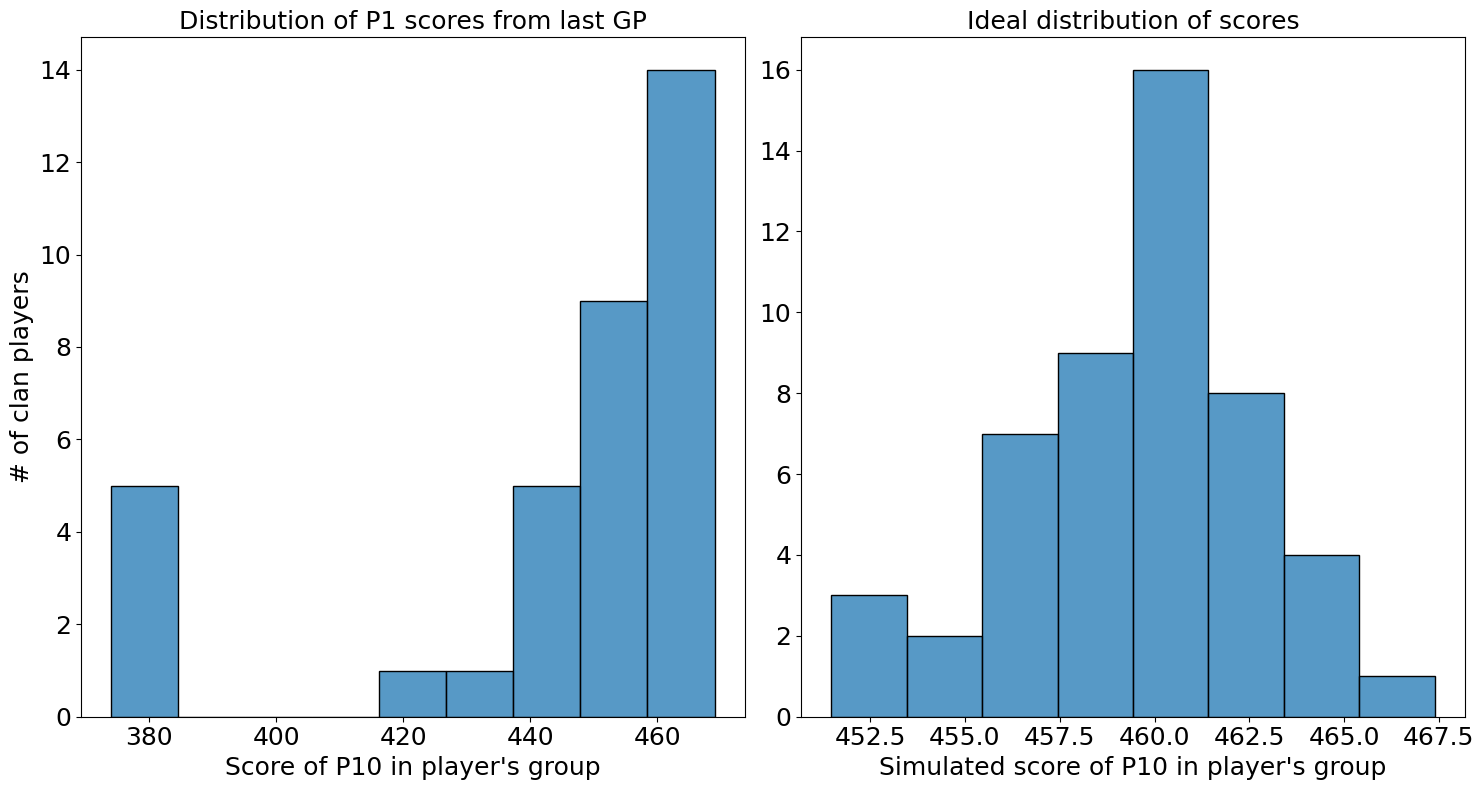

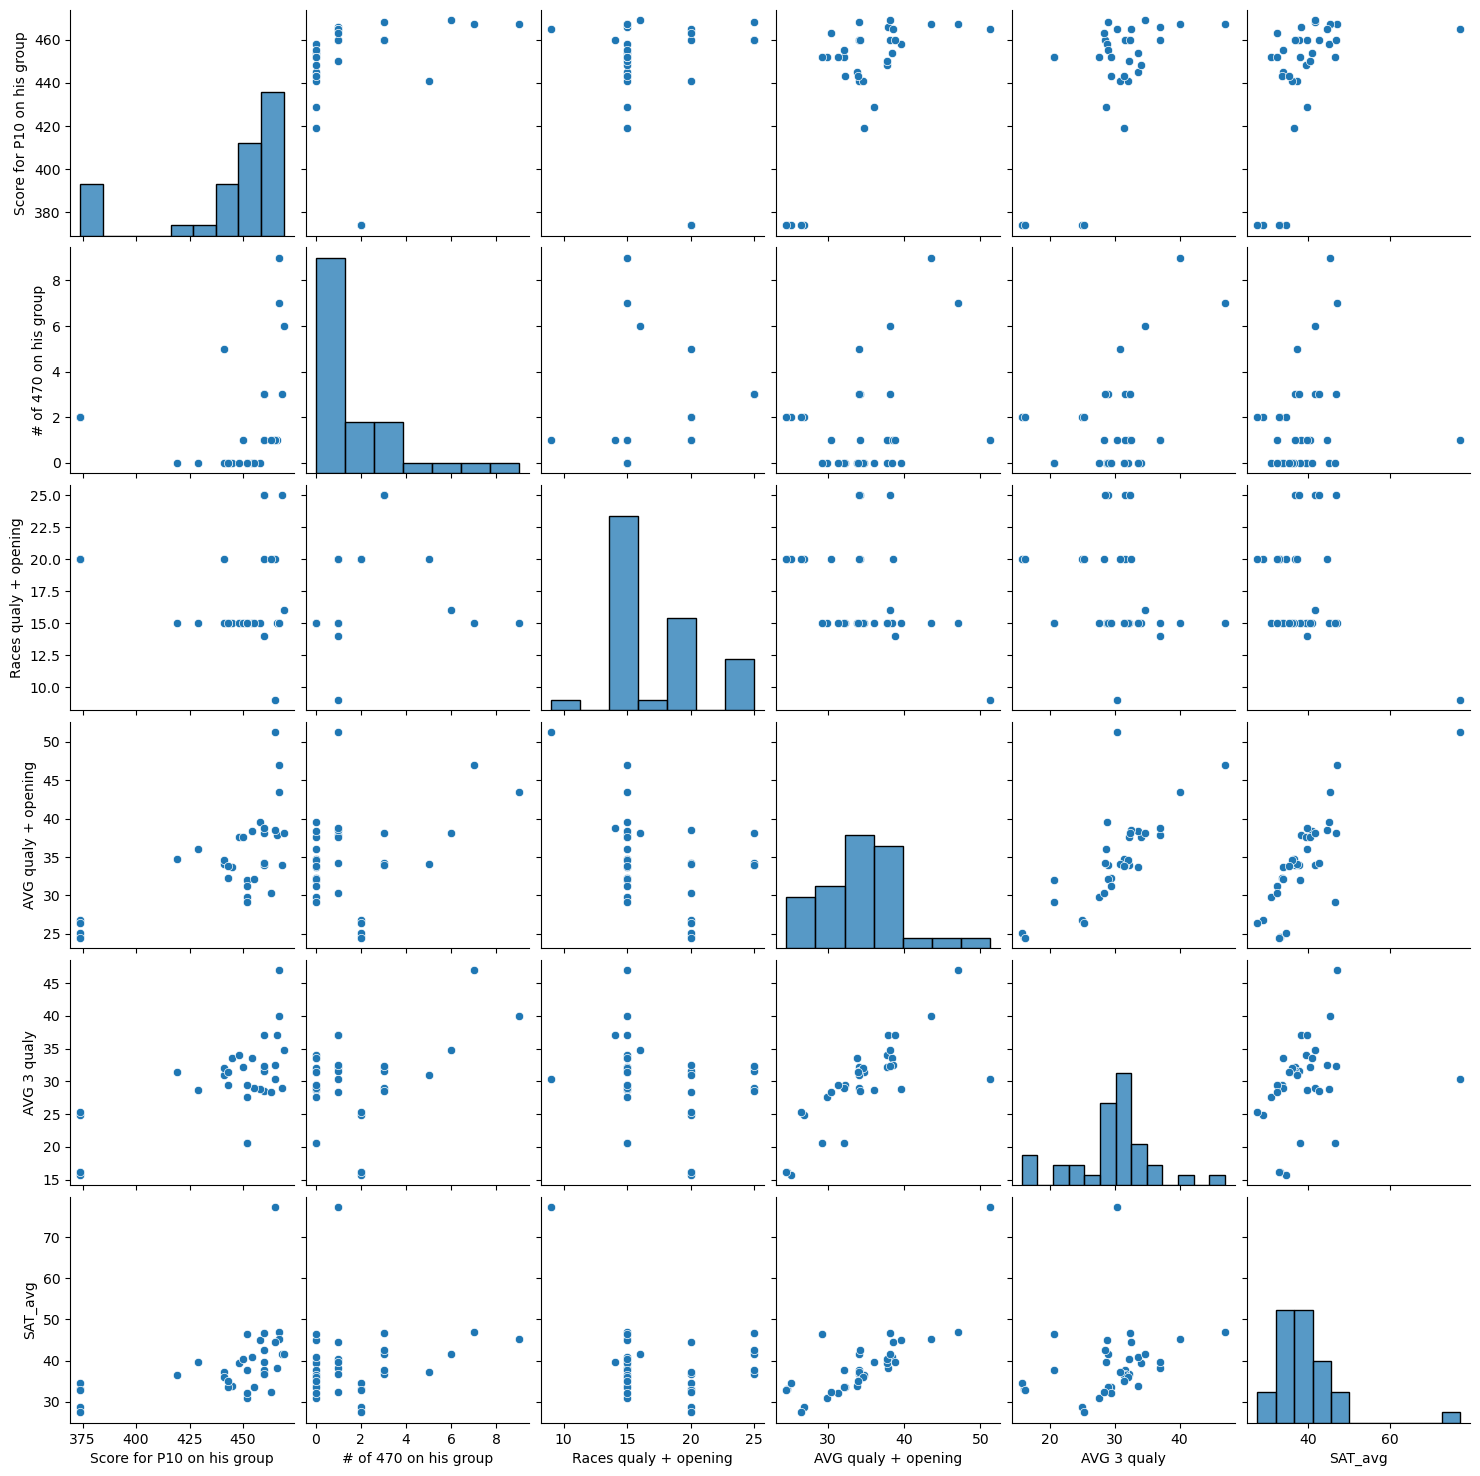

In [18]:
sns.pairplot(cleaned_data_regression_2)
plt.show()
# plt.savefig('../visual.png')

#### This looks better! But there seems to be a strong co-linearity between average for qualy, and average for Saturday. In a way, this simply reflects strategies: Players sandbagging on both stages (to various degrees), or players going all in at every stage.

C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in 

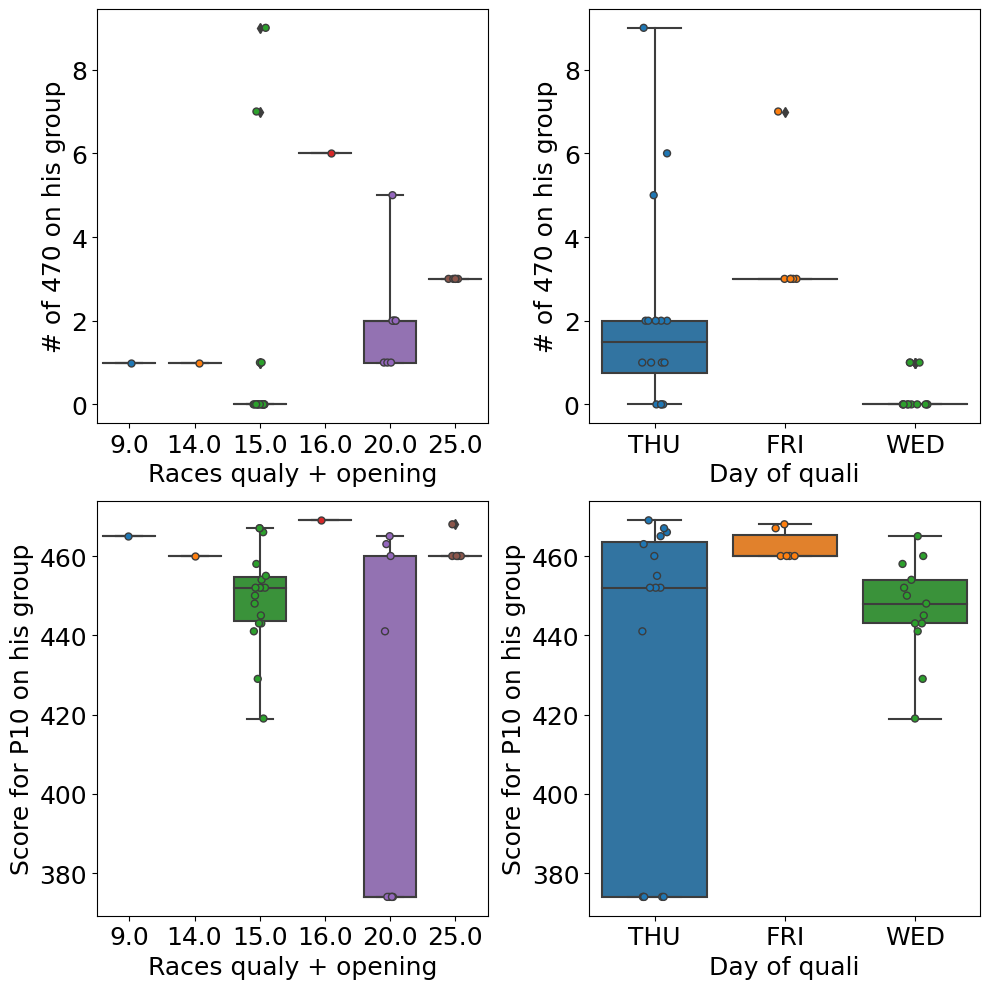

In [20]:
fig5,ax5 = plt.subplots(2,2, figsize=(10,10))
sns.stripplot(x="Races qualy + opening", y="# of 470 on his group",
              data=cleaned_data_regression_2, ax=ax5[0,0], linewidth=1)
sns.boxplot(x="Races qualy + opening", y="# of 470 on his group",
            data=cleaned_data_regression_2, ax=ax5[0,0], whis=np.inf)
ax5[0,0].set_ylabel('# of 470 on his group', size=18)
ax5[0,0].set_xlabel("Races qualy + opening", size=18)
ax5[0,0].tick_params(axis='x', labelsize=18)
ax5[0,0].tick_params(axis='y', labelsize=18)

sns.stripplot(x="Actual qualy day", y="# of 470 on his group",
              data=cleaned_data_regression_2, ax=ax5[0,1], linewidth=1)
sns.boxplot(x="Actual qualy day", y="# of 470 on his group",
            data=cleaned_data_regression_2, ax=ax5[0,1], whis=np.inf)
ax5[0,1].set_ylabel('# of 470 on his group', size=18)
ax5[0,1].set_xlabel("Day of quali", size=18)
ax5[0,1].tick_params(axis='x', labelsize=18)
ax5[0,1].tick_params(axis='y', labelsize=18)

sns.stripplot(x="Races qualy + opening", y="Score for P10 on his group",
              data=cleaned_data_regression_2, ax=ax5[1,0], linewidth=1)
sns.boxplot(x="Races qualy + opening", y="Score for P10 on his group",
            data=cleaned_data_regression_2, ax=ax5[1,0], whis=np.inf)
ax5[1,0].set_ylabel('Score for P10 on his group', size=18)
ax5[1,0].set_xlabel("Races qualy + opening", size=18)
ax5[1,0].tick_params(axis='x', labelsize=18)
ax5[1,0].tick_params(axis='y', labelsize=18)

sns.stripplot(x="Actual qualy day", y="Score for P10 on his group",
              data=cleaned_data_regression_2, ax=ax5[1,1], linewidth=1)
sns.boxplot(x="Actual qualy day", y="Score for P10 on his group",
              data=cleaned_data_regression_2, ax=ax5[1,1], whis=np.inf)
ax5[1,1].set_ylabel('Score for P10 on his group', size=18)
ax5[1,1].set_xlabel("Day of quali", size=18)
ax5[1,1].tick_params(axis='x', labelsize=18)
ax5[1,1].tick_params(axis='y', labelsize=18)

plt.tight_layout()
plt.savefig("difficulty_group_races.png")
plt.show()

#### Linear regression
This is looking better, so I'll further rescale the variables so the results can be better interpreted

In [ ]:
# Don't want to deal with the numpy -> pandas conversion
# AKA, no sklearn
features = cleaned_data_regression_2[['AVG qualy + opening', 'Races qualy + opening',
                           'AVG 3 qualy','SAT_avg']]

cleaned_data_regression_2[['AVG qualy + opening',
                'Races qualy + opening',
                'AVG 3 qualy',
                'SAT_avg']] = (features - features.min())/(features.max() -features.min())

In [ ]:
print(f"Number of players with complete average data: {len(cleaned_data_regression_2)}")

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
features = cleaned_data_regression_2[['AVG qualy + opening', 'Races qualy + opening', 'SAT_avg', 'AVG 3 qualy', 'Actual qualy day']]
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [4])], remainder='passthrough')
trans_features = ct.fit_transform(features)
features_trans = pd.DataFrame(trans_features, index=features.index, columns=['THU','WED',
                                                                             'AVG qualy + opening',
                                                                             'Races qualy + opening',
                                                                             'SAT_avg','AVG 3 qualy'])
features_trans = sm.add_constant(features_trans)

## \# of 470

In [ ]:
response = cleaned_data_regression_2['# of 470 on his group']
model = sm.OLS(response, features_trans)
smOLS = model.fit()
smOLS.summary()

In [ ]:
model = sm.OLS(response, features_trans.drop(columns=['THU']))
smOLS = model.fit()
smOLS.summary()

In [ ]:
model = sm.OLS(response, features_trans.drop(columns=['THU','const']))
smOLS = model.fit()
smOLS.summary()

In [ ]:
model = sm.OLS(response, features_trans.drop(columns=['THU', 'const', 'AVG 3 qualy']))
smOLS = model.fit()
smOLS.summary()

In [ ]:
model = sm.OLS(response, features_trans.drop(columns=['THU', 'const', 'AVG 3 qualy', 'SAT_avg']))
smOLS = model.fit()
smOLS.summary()

In [ ]:
model = sm.OLS(response, features_trans.drop(columns=['THU', 'const', 'AVG 3 qualy', 'SAT_avg', 'Races qualy + opening']))
smOLS = model.fit()
smOLS.summary()

### Score of P10

In [ ]:
response = cleaned_data_regression_2["Score for P10 on his group"]
model = sm.OLS(response, features_trans)
smOLS = model.fit()
smOLS.summary()

In [ ]:
model = sm.OLS(response, features_trans.drop(columns=['Races qualy + opening']))
smOLS = model.fit()
smOLS.summary()

In [ ]:
model = sm.OLS(response, features_trans.drop(columns=['Races qualy + opening','AVG qualy + opening']))
smOLS = model.fit()
smOLS.summary()

In [ ]:
model = sm.OLS(response, features_trans.drop(columns=['Races qualy + opening','AVG qualy + opening', 'THU']))
smOLS = model.fit()
smOLS.summary()

In [ ]:
model = sm.OLS(response, features_trans.drop(columns=['Races qualy + opening','AVG qualy + opening', 'THU', 'WED']))
smOLS = model.fit()
smOLS.summary()

## Yeap, cannot conclude much from Linear Regression. When evaluating each average individually (not shown), I couldn't also see statistically significant coefficients.  
  
  ### Idea: Let's use score of whoever ends on P10 as the measure of easiness of the Sunday group. I expect this score to follow a bell curve better than the score of P1 (which is very skewed towards 470). Essentially, that will be the score above which players could get good medals in the event, and not just the generic finalist medal. It will also be on the same terms as the other variables, since they are also scores. I could simply divide those scores by 10, and then normalize, to have very pretty dataset for linear regression.

However, there are other ideas floating around. It turns out that players ending up together on Saturday's Opening round tend to also end up together in the Final round. It would be difficult to assess that with this data, since players may sandbag or go all-in on Saturday, so their scores aren't a reflection of their true skill level.  
But I could test, later on, if this notion is true, if I quantify clustering on saturday, and see if it is any different on sunday. The problem there is that I would need data on all players, not just Elite F1.

#### Let's simply look at groups, whether they share general traits

In [ ]:
groupings_data = raw_data[['Player', 'SUN DAY group', 'SAT group', 'AVG qualy + opening',
                           'SAT score', 'SAT races', 'AVG 3 qualy', 'Races qualy + opening', 'Actual qualy day']]

groupings_data['SAT_avg'] = groupings_data['SAT score']/groupings_data['SAT races']
groupings_data = groupings_data[['SUN DAY group','SAT group',
                                 'AVG qualy + opening', 'SAT_avg',
                                 'AVG 3 qualy', 'Races qualy + opening', 'Actual qualy day']]

# taking away those without entries for Sunday groups
groupings_data = groupings_data.dropna(how='all',
                                       subset=['SUN DAY group'])

# taking away those without entries for averages
groupings_data = groupings_data.dropna(how='any',
                                       subset=['AVG qualy + opening',
                                               'SAT_avg',
                                               'AVG 3 qualy'])

groupings_data.sort_values(by='SUN DAY group')

#### Sunday grouping logic

In [ ]:
# Taking away groups where only one person was present
# f = groupings_data['SUN DAY group'].value_counts()
# groupings_data = groupings_data[groupings_data['SUN DAY group'].isin(f[f>1].index)]

In [ ]:
fig1, ax1 = plt.subplots(1,3, figsize=(18,7))
sns.boxplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data, ax=ax1[0], whis=np.inf)
sns.stripplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data, ax=ax1[0], linewidth=1)
ax1[0].set_title("Is it overall average?")

sns.boxplot(x="SAT_avg", y="SUN DAY group",
              data=groupings_data, ax=ax1[1], whis=np.inf)
sns.stripplot(x="SAT_avg", y="SUN DAY group",
              data=groupings_data, ax=ax1[1], linewidth=1)
ax1[1].set(ylabel=None)
ax1[1].set_title("Is it Saturday average?")

sns.boxplot(x="AVG 3 qualy", y="SUN DAY group",
              data=groupings_data, ax=ax1[2], whis=np.inf)
sns.stripplot(x="AVG 3 qualy", y="SUN DAY group",
              data=groupings_data, ax=ax1[2], linewidth=1)
ax1[2].set(ylabel=None)
ax1[2].set_title("Is it just Quali average?")

plt.tight_layout()
plt.show()
# plt.savefig("grouping_by_average.png")

#### Saturday logic

In [ ]:
fig2, ax2 = plt.subplots(1,1)
sns.boxplot(x="AVG 3 qualy", y="SAT group",
              data=groupings_data.dropna(), ax=ax2, whis=np.inf)
sns.stripplot(x="AVG 3 qualy", y="SAT group",
              data=groupings_data.dropna(), ax=ax2, linewidth=1)

plt.show()

In [ ]:
fig3, ax3 = plt.subplots(1,1)
sns.boxplot(x="Races qualy + opening", y="SUN DAY group",
              data=groupings_data, ax=ax3, whis=np.inf)
sns.stripplot(x="Races qualy + opening", y="SUN DAY group",
              data=groupings_data, ax=ax3, linewidth=1)

# plt.savefig("number_of_races.png")
plt.show()

### Co-occurrence of Saturday group vs. Sunday group

In [ ]:
groupings = groupings_data[['SUN DAY group','SAT group', 'Races qualy + opening',
                            'Actual qualy day']].dropna()
f = groupings['SAT group'] != '-'
groupings.loc[f].sort_values(by='SAT group')

## there seems to be a hierarchy or a sequential criteria applied to determine groups. Among those with 15 races, what was their average?

In [ ]:
g = groupings_data['Races qualy + opening'] == 15
h = groupings_data['Races qualy + opening'] == 20
k = groupings_data['Races qualy + opening'] == 25

fig4, ax4 = plt.subplots(1,3,figsize=(18,7))
sns.boxplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[g], ax=ax4[0], whis=np.inf)
sns.stripplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[g], ax=ax4[0], linewidth=1)
ax4[0].set_title("15 races")

sns.boxplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[h], ax=ax4[1], whis=np.inf)
sns.stripplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[h], ax=ax4[1], linewidth=1)
ax4[1].set_title("20 races")

sns.boxplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[k], ax=ax4[2], whis=np.inf)
sns.stripplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[k], ax=ax4[2], linewidth=1)
ax4[2].set_title("25 races")

plt.tight_layout()
# plt.savefig("average_spread_per_races.png")
plt.show()

hum, does it happens because we have more groups in one they them the other?
We had 10 groups for weds, 2 groups for thurs and 1 for friday  
10 groups for people who qualified with 5 races;
2 groups for people who qualified with 10 races;
1 groups for people whi qualified with 15

In [ ]:
sun_friday = raw_data[['SUN DAY group', 'SAT group',
                       'Races 3 qualy',
                       'Actual qualy day']].dropna(subset=['SUN DAY group', 'Actual qualy day', 'Races 3 qualy'])
sun_friday.groupby('Races 3 qualy')['SUN DAY group'].unique()

In [ ]:
sun_friday.groupby('Races 3 qualy')['SUN DAY group'].nunique()